Mounted at /content/drive
Found 528 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating ResNet50 on the test dataset...
17/17 ━━━━━━━━━━━━━━━━━━━━ 179s 11s/step - accuracy: 0.1977 - loss: 1.7617
Test Loss: 1.7086
Test Accuracy: 0.3144
Evaluation Time: 203.13 seconds

Generating predictions for ResNet50...
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step


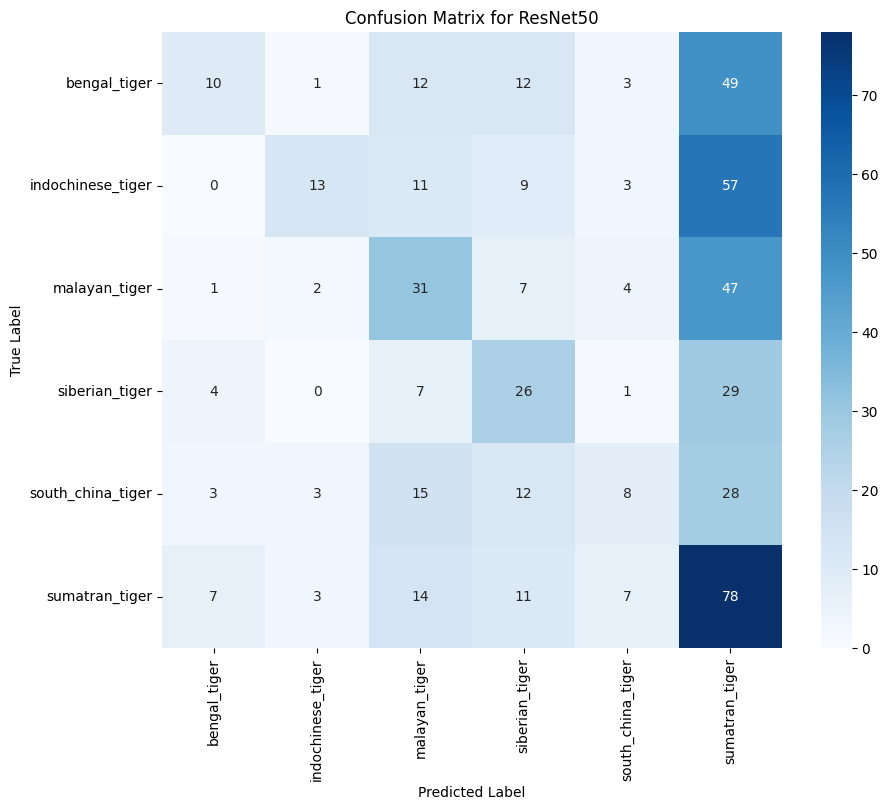


Classification Report for ResNet50:
                   precision    recall  f1-score   support

     bengal_tiger       0.40      0.11      0.18        87
indochinese_tiger       0.59      0.14      0.23        93
    malayan_tiger       0.34      0.34      0.34        92
   siberian_tiger       0.34      0.39      0.36        67
south_china_tiger       0.31      0.12      0.17        69
   sumatran_tiger       0.27      0.65      0.38       120

         accuracy                           0.31       528
        macro avg       0.38      0.29      0.28       528
     weighted avg       0.37      0.31      0.28       528


Calculating mAP for ResNet50...
Mean Average Precision (mAP): 0.2891

Evaluating DenseNet121 on the test dataset...
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step - accuracy: 0.4325 - loss: 1.3652
Test Loss: 1.3288
Test Accuracy: 0.4848
Evaluation Time: 46.29 seconds

Generating predictions for DenseNet121...
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 752ms/step


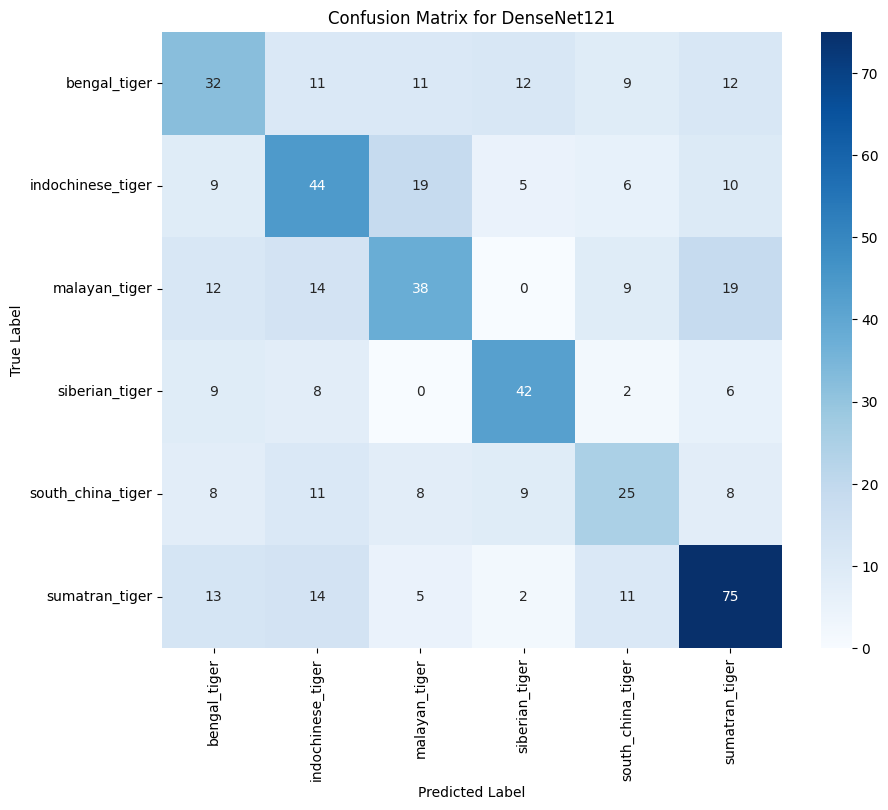


Classification Report for DenseNet121:
                   precision    recall  f1-score   support

     bengal_tiger       0.39      0.37      0.38        87
indochinese_tiger       0.43      0.47      0.45        93
    malayan_tiger       0.47      0.41      0.44        92
   siberian_tiger       0.60      0.63      0.61        67
south_china_tiger       0.40      0.36      0.38        69
   sumatran_tiger       0.58      0.62      0.60       120

         accuracy                           0.48       528
        macro avg       0.48      0.48      0.48       528
     weighted avg       0.48      0.48      0.48       528


Calculating mAP for DenseNet121...
Mean Average Precision (mAP): 0.5308

--- Final Summary ---
Model                | Accuracy   | Loss       | Eval Time (s)   | mAP       
----------------------------------------------------------------------
ResNet50             | 0.3144     | 1.7086     | 203.13          | 0.2891    
DenseNet121          | 0.4848     | 1.3288  

In [1]:
# 1. Mount Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
import time

# 2. Setup
test_dir = '/content/drive/MyDrive/test'  # <- make sure this is your test folder
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
class_labels = list(test_generator.class_indices.keys())

# 3. Load models
models = {
    'ResNet50': load_model('/content/drive/MyDrive/resnet50_tiger_model.h5'),
    'DenseNet121': load_model('/content/drive/MyDrive/densenet121_tiger_model.h5'),
    #'MobileNetV3Large': load_model('/content/drive/MyDrive/mobilenetv3_tiger_model.h5')
}

# 4. Evaluate models
evaluation_results = {}

for name, model in models.items():
    print(f"\nEvaluating {name} on the test dataset...")
    start = time.time()
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    duration = time.time() - start
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Evaluation Time: {duration:.2f} seconds")

    print(f"\nGenerating predictions for {name}...")
    y_true = test_generator.classes
    y_probs = model.predict(test_generator)
    y_pred = np.argmax(y_probs, axis=1)

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))

    # mAP
    print(f"\nCalculating mAP for {name}...")
    aps = []
    for i in range(len(class_labels)):
        y_true_i = (y_true == i).astype(int)
        y_score_i = y_probs[:, i]
        if np.sum(y_true_i) > 0 and len(np.unique(y_true_i)) > 1:
            aps.append(average_precision_score(y_true_i, y_score_i))
        else:
            aps.append(0.0)
    mean_ap = np.mean(aps)
    print(f"Mean Average Precision (mAP): {mean_ap:.4f}")

    evaluation_results[name] = {
        'Test Accuracy': test_acc,
        'Test Loss': test_loss,
        'Evaluation Time': duration,
        'mAP': mean_ap
    }

# 5. Final Summary
print("\n--- Final Summary ---")
print(f"{'Model':<20} | {'Accuracy':<10} | {'Loss':<10} | {'Eval Time (s)':<15} | {'mAP':<10}")
print("-" * 70)
for name, res in evaluation_results.items():
    print(f"{name:<20} | {res['Test Accuracy']:<10.4f} | {res['Test Loss']:<10.4f} | {res['Evaluation Time']:<15.2f} | {res['mAP']:<10.4f}")
print("-" * 70)
